In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split


Let's load our data and look at some of the data we have

In [4]:
housing_data = pd.read_csv("../data/external/housing.csv")
housing_data.head()


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


I decided to drop the date columns from the orignal data just to make it easier to work with.

In [5]:
housing_data = housing_data.drop(columns='date', axis=1)
housing_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


Before we start to do any data exploration we should split the data into a training set, validation set, and a test set. We will be exploring the data mainly using the training sets and if necessary, the validation sets.

In [9]:
X = housing_data.iloc[:, 1:]# all columns besides the price column
y = housing_data.iloc[:, :1]# only the price column
X_main, X_test, y_main, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, random_state = 42, test_size =0.33)
train_df = pd.concat([X_train, y_train], axis = 1)

For the housing data, it is all contained within Washington State, USA. The only thing that changes geographically is the cities, so we will ignore any qualitative data regarding location and focus on the numerical attributes. We also want to check if there is any missing data.

In [7]:
num_values_missing = X_test.isna().sum()
print(num_values_missing)

bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64


Our target variable is price, and we want to find out which features have a high correlation with the target variable. We can check for linear correlation between price and the other attributes by using the corr() method.

In [10]:
corr_matrix = train_df.corr(numeric_only = True)
corr_matrix['price'].sort_values(ascending = False)

price            1.000000
sqft_living      0.688127
sqft_above       0.573148
bathrooms        0.519621
sqft_basement    0.369648
view             0.361384
bedrooms         0.344647
floors           0.250161
waterfront       0.163751
sqft_lot         0.066283
condition        0.062663
yr_built         0.042542
yr_renovated    -0.052996
Name: price, dtype: float64

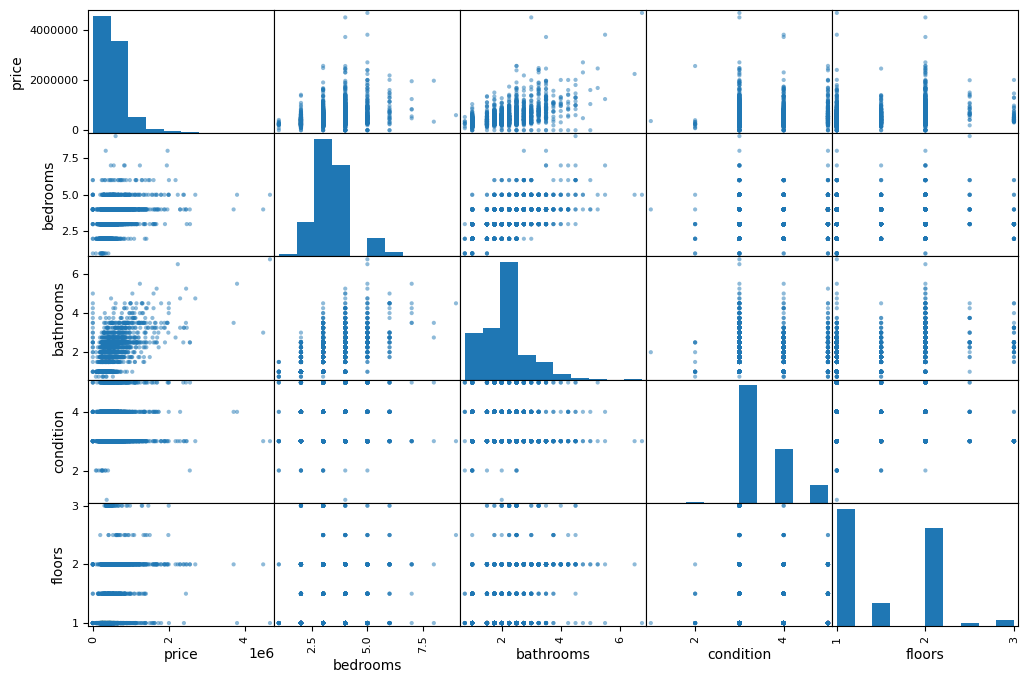

In [11]:
attributes = ["price","bedrooms", "bathrooms", "condition","floors"]
scatter_matrix(train_df[attributes], figsize = (12,8))
plt.show()

The above figures display most of the categorical attributes found in our dataset so it's hard to tell
the correlation between all of them. Now let's plot out more contionus variables and see if we can make some conclusions

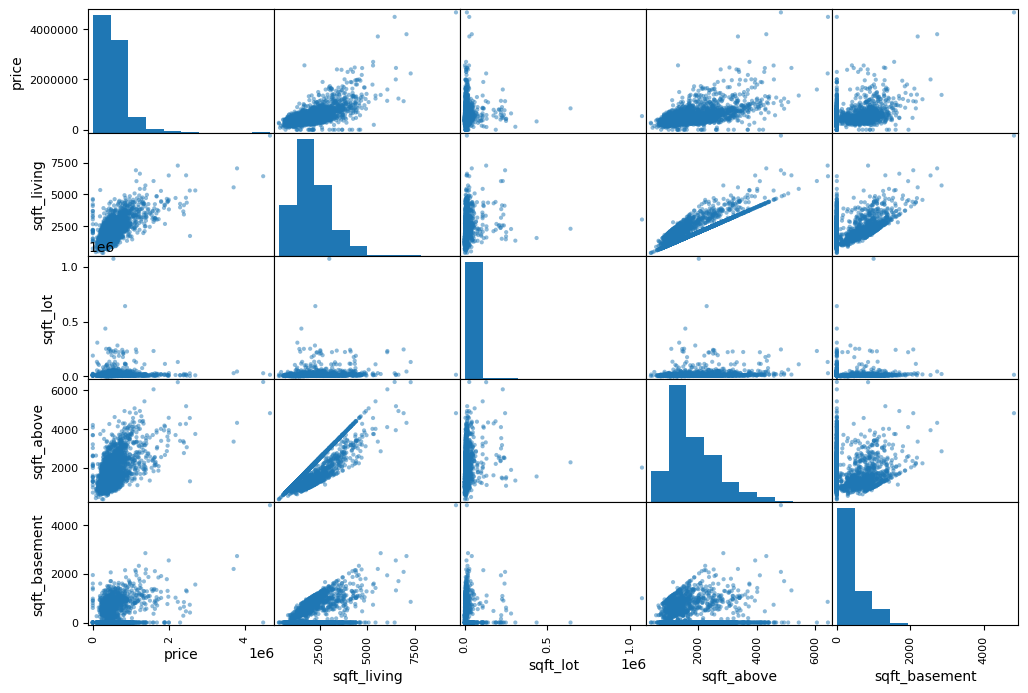

In [12]:
attributes = ["price","sqft_living", "sqft_lot", "sqft_above", 'sqft_basement']
scatter_matrix(train_df[attributes], figsize = (12,8))
plt.show()

There is definitely a lot more visible correlation with the continous attributes which is to be expected. Now I would like to look at plots that look at price vs the other attributes but with price as the y-axis. For the sqft attributes, the histograms are skewed to the right and might be worth eventually transforming by taking the respective logarithms or square roots.

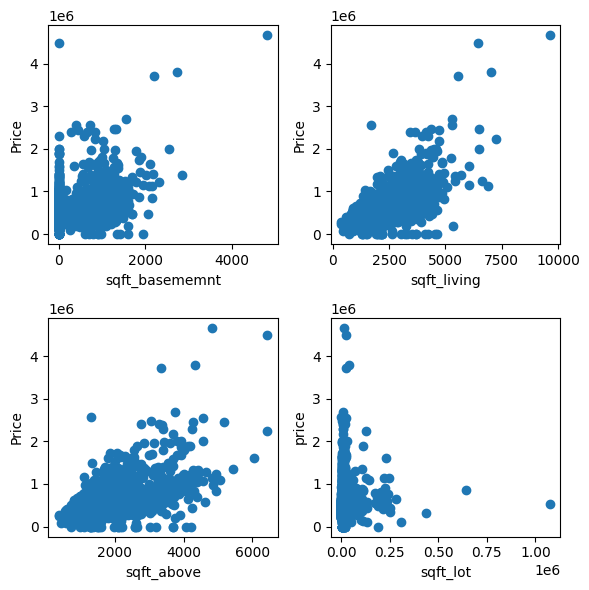

In [13]:
fig, ax = plt.subplots(2,2, figsize = (6,6))

ax[0,0].scatter(train_df['sqft_basement'], train_df['price'])
ax[0,0].set_xlabel('sqft_basememnt')
ax[0,0].set_ylabel('Price')

ax[0,1].scatter(train_df['sqft_living'], train_df['price'])
ax[0,1].set_xlabel('sqft_living')
ax[0,1].set_ylabel('Price')

ax[1,0].scatter(train_df['sqft_above'], train_df['price'])
ax[1,0].set_xlabel('sqft_above')
ax[1,0].set_ylabel('Price')


ax[1,1].scatter(train_df['sqft_lot'], train_df['price'])
ax[1,1].set_xlabel('sqft_lot')
ax[1,1].set_ylabel('price')


plt.tight_layout()
plt.show()

Due to a couple of outliers in price, the majority of the data is stuck at the bottom of the plots, so it will be worth eventually scaling our price column or getting rid of the outliers.

# Feature Scaling

Looking at the histogram of the sqft-related attributes that we plotted, they all seem to be skewed towards the right. For sqft_lot, we'll take the logarithm of it. For sqft_living and sqft_above we will take the square root since the skewness is milder. For sqft_basement it's skewed since there is a considerable amount of houses with no basement which is why sqft_basement is 0 for those houses. It will be split up into two new columns has_basement, which indicates whether the house has a basement or not and sqft_basement_nonzero contains the amount of square feet the basement has for the houses that do have a basement.


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
